Pre laods all modules for use in script

In [8]:
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
import numpy as np
from PIL import Image
from keras.preprocessing import image
from skimage.io import imread
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## OPTIONAL STEP ## This code simply converts image files from tif to png format. The initial files were TIFs, however there is no in-built converter for tifs in tensorflow so the dataset was pre-converted into png files. 

In [ ]:
for file in glob.glob("*.tif"):
    im = Image.open(file)
    rgb_im = im.convert('RGB')
    rgb_im.save(file.replace("tif", "png"), quality=100)

#### Sets working directory, house keeping. Would need to be set to users preferred WD. 

In [9]:
os.chdir(r'C:\Users\cr1349\OneDrive - University of Bristol\Documents\Col_sub_images')

### Searches through all folders within the specified directory and takes the file path of all files within and appends them to a numpy array (list). Note: to ensure the correct ordering of the two categories of image files within the list user should place the injured heart images into a subfolder named "Injured" and the sham heart images into a file named "Sham", both of which should be placed inside a folder which is the target of this script i.e "image_data_for_cnn".

In [10]:
file_list = []

# Initially Col_sub_images was set to "." which caused an issue where jupyter notebooks and other files, 
# which were saved into root dir, would be incorpoated into re-runs of this script resulting in un-even list lengths, so directory route needed to be changed.
# note: both Col_sub_images and dirName will need to be changed to users file path containing heart image data for analysis

# Was changed to a numpy array to better fucntion with tensorflow. 

Col_sub_images = "C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn"  
def getListOfFiles(image_data_for_cnn):           
   
    listOfFile = os.listdir(image_data_for_cnn)
    allFiles = list()
   
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(Col_sub_images, entry)
       
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles  

def main():
    
    dirName = r'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn';
    
   
    listOfFiles = getListOfFiles(dirName)
  
    
    
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
        
        
    # Append the files to the list    
    for elem in listOfFiles:
        file_list.append(elem) 
        
if __name__ == '__main__':
    main()
    
file_list = np.asarray(file_list)
file_list #prints the array to check that the file paths are correct and that no incorrect files have been incorporated into the list

array(['C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_1.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_2.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_3.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_4.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_5.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_1_6.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_2_1.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/image_data_for_cnn\\Injured\\inj_2_2.png',


## Creating a numpy array (list) that contains a number of 0s and 1s (labels) equal to the number half of the total number of images (taken from the file_list). Note: this assumes an equal number of image files within the injred and sham sub folders, and relies on the injured file paths being appended to the file_list array before the sham files.

In [11]:
labels_list = []
x = 1
y = 0                         # Initially had labels as "injured" and "sham", however tensorflow does not take strings as an input, so changed the labels to 1 & 0 where 1= injured and 0= sham

i = int((len(file_list)/2))   # Initially had manually set the number of times to extend the list to 36 (the size of my dataset), however this method is more flexible as it allows the input size to be changed depending on the number of files

labels_list.extend([x]*i)
labels_list.extend([y]*i)

labels_list = np.asarray(labels_list)
labels_list

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

## Defining a parse function that is later invoked in the creation of the tensorflow dataset

In [12]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    print(filename)
   
    image = tf.image.decode_png(image_string, channels=3)   # Decodes the .png images in colour (RGB)

    
    image = tf.image.convert_image_dtype(image, tf.float32) # Converts to float values in [0, 1]
    
    image = tf.image.resize(image, [100 , 100])             # Manual specification of the image size is required for the tensorflow dataset shape to be propperly defined, here they are set to 100x100 pixels. 
    
    return image, label

## Creating the TensorFlow datset from slices of the file_list and labels_list. First the batch size is set and the portion of the dataset to be split into testing, training and validation sub-sets. The full dataset must be parsed first, secondary parsing of the data results in errors. The dataset is cashed and shuffled. Then the dataset is divided and then the sub-datasets batched.

In [ ]:
batch_size = 6
train_size = int(0.7 * len(file_list))
val_size = int(0.15 * len(file_list))
test_size = int(0.15 * len(file_list))

full_dataset = tf.data.Dataset.from_tensor_slices((file_list, labels_list))
full_dataset = full_dataset.cache()
full_dataset = full_dataset.map(parse_function, num_parallel_calls=4) # Invokes parse function to transform dataset to float32 and provide shape - initial iterations created the dataset, but the arrays contained elelemnts with "none" values for shape
full_dataset = full_dataset.shuffle(len(file_list))
full_dataset = full_dataset.prefetch(1) # Increases speed at cost of more RAM usage

train_dataset = full_dataset.take(train_size) # To be used to fit the model & train
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)
test_dataset = test_dataset.prefetch(1)

train_dataset = full_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(1)


val_dataset = full_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(1)


test_dataset = full_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(1)



print(test_dataset)
for element in test_dataset: 
    print(element)
    

## Next the model variables are defined and the model is compiled, only minor changes to the borrowed code were required to allow this model to accept the heart image dataset.

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers.advanced_activations import LeakyReLU

max_pool = tf.keras.layers.MaxPool2D((2, 2), (2, 2), padding='same')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=5,
        padding="same",
        activation=tf.nn.relu, 
    input_shape=(100, 100, 3)), #changed input shape to match that of my files - 100x100 pixels, RGB
    max_pool,
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        padding="same",
        activation=tf.nn.relu),

    max_pool,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

## model.fit() fits the model using the training and validation dataset, essentially training the model for later use on new images. 

In [15]:
model.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
)

Epoch 1/10
12/12 [==============================] - 5s 310ms/step - loss: 1.3351 - accuracy: 0.4842 - val_loss: 0.5502 - val_accuracy: 0.7361
Epoch 2/10
12/12 [==============================] - 2s 130ms/step - loss: 0.6988 - accuracy: 0.6751 - val_loss: 0.3903 - val_accuracy: 0.8611
Epoch 3/10
12/12 [==============================] - 1s 113ms/step - loss: 0.5337 - accuracy: 0.7219 - val_loss: 0.2873 - val_accuracy: 0.9306
Epoch 4/10
12/12 [==============================] - 2s 133ms/step - loss: 0.2435 - accuracy: 0.9345 - val_loss: 0.1353 - val_accuracy: 0.9722
Epoch 5/10
12/12 [==============================] - 2s 136ms/step - loss: 0.1433 - accuracy: 0.9644 - val_loss: 0.0907 - val_accuracy: 0.9583
Epoch 6/10
12/12 [==============================] - 2s 135ms/step - loss: 0.1516 - accuracy: 0.9208 - val_loss: 0.1298 - val_accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 2s 120ms/step - loss: 0.1213 - accuracy: 0.9578 - val_loss: 0.0701 - val_accuracy: 0.9861
Epoch 

In [16]:
model.save('heart_inj_model.h5') 
# Saves the model. Initial plan was to recall the model and use model.predict.classes() on a single image, however this approach
# proved difficult to impliment, with the size of the single image not matching the expected input size for certain layers of the model.

In [17]:
model.summary() #displayes summary of the model, indicating expected shape of inputs /outputs.  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        12832     
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2560128   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [18]:
probabilities = model.predict(test_dataset)

Takes the test dataset and runs the fitted model on it, giving classifications for the images 1 = Injured and 0 = Uninjured.

In [25]:
truths = list(range(1, 10))

table = []
for truth, probs in zip(truths, probabilities):
    prediction = probs.argmax()
    if truth == 'injured':
        print(f"{truth}. model identifies image as category {prediction} with a confidence of ({probs[prediction]*100:.1f}%)")
    else:
        print(f"{truth} at {probs[truth]*100:4.1f}%. model identifies image as category {prediction} with a confidence of ({probs[prediction]*100:4.1f}%)")
    table.append((truth, probs))
    
print("Where 1 = Injured, 0 = Uninjured")

1 at 100.0%. model identifies image as category 1 with a confidence of (100.0%)
2 at  0.0%. model identifies image as category 1 with a confidence of (99.5%)
3 at  0.0%. model identifies image as category 0 with a confidence of (99.9%)
4 at  0.0%. model identifies image as category 0 with a confidence of (100.0%)
5 at  0.0%. model identifies image as category 1 with a confidence of (100.0%)
6 at  0.0%. model identifies image as category 1 with a confidence of (99.8%)
7 at  0.0%. model identifies image as category 0 with a confidence of (100.0%)
8 at  0.0%. model identifies image as category 0 with a confidence of (100.0%)
9 at  0.0%. model identifies image as category 1 with a confidence of (100.0%)
Where 1 = Injured, 0 = Uninjured


### A second batch of the same images can now be fed back into the model, without shuffling the images to allow human validation of the models prediction. Here the same methodology is used for creating the TensorFlow dataset and decoding the images. This seperate batch of images are manually placed into a sperate folder called "Val_data", in this example 3 injured and 3 sham images are used. 

In [20]:
val_file_list = []

Col_sub_images = "C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data"  
def getListOfFiles(image_data_for_cnn):           
   
    listOfFile = os.listdir(image_data_for_cnn)
    allFiles = list()
   
    for entry in listOfFile:
    
        fullPath = os.path.join(Col_sub_images, entry)
       
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles  

def main():
    
    dirName = r'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data';
    
   
    listOfFiles = getListOfFiles(dirName)
  
    
    
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(dirName):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
        
        
    # Append the files to the list    
    for elem in listOfFiles:
        val_file_list.append(elem) 
        
if __name__ == '__main__':
    main()
    
val_file_list = np.asarray(val_file_list)
val_file_list #prints the array to check that the file paths are correct and that no incorrect files have been incorporated into the list

array(['C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Inj\\inj_1_1.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Inj\\inj_1_2.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Inj\\inj_1_3.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Sham\\shm_1_1.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Sham\\shm_1_2.png',
       'C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Sham\\shm_1_3.png'],
      dtype='<U103')

In [21]:
val_labels_list = []
x = 1
y = 0                         
i = int((len(val_file_list)/2))   
val_labels_list.extend([x]*i)
val_labels_list.extend([y]*i)

val_labels_list = np.asarray(val_labels_list)
val_labels_list

array([1, 1, 1, 0, 0, 0])

In [ ]:
val_full_dataset = tf.data.Dataset.from_tensor_slices((val_file_list, val_labels_list))
val_full_dataset = val_full_dataset.map(parse_function, num_parallel_calls=4) # Invokes parse function to transform dataset to float32 and provide shape - initial iterations created the dataset, but the arrays contained elelemnts with "none" values for shape
val_full_dataset = val_full_dataset.prefetch(1) 
val_full_dataset = val_full_dataset.batch(6) # If the dataset is not batched then the CNN fails to accept the input shape, can this be made flexible?

print(val_full_dataset)
for element in val_full_dataset: 
    print(element)

In [23]:
val_probabilities = model.predict(val_full_dataset)

In [24]:
truths = list(range(1, 7)) 

table = []
for truth, probs in zip(truths, val_probabilities):
    prediction = probs.argmax()
    if truth == 'injured':
        print(f"{truth}. model identifies image as category {prediction} with a confidence of ({probs[prediction]*100:.1f}%)")
    else:
        print(f"{truth} at {probs[truth]*100:4.1f}%. model identifies image as category {prediction} with a confidence of ({probs[prediction]*100:4.1f}%)")
    table.append((truth, probs))
    
print("Where 1 = Injured, 0 = Uninjured")

1 at 99.4%. model identifies image as category 1 with a confidence of (99.4%)
2 at  0.0%. model identifies image as category 1 with a confidence of (99.4%)
3 at  0.0%. model identifies image as category 1 with a confidence of (100.0%)
4 at  0.0%. model identifies image as category 0 with a confidence of (100.0%)
5 at  0.0%. model identifies image as category 0 with a confidence of (99.9%)
6 at  0.0%. model identifies image as category 0 with a confidence of (100.0%)
Where 1 = Injured, 0 = Uninjured


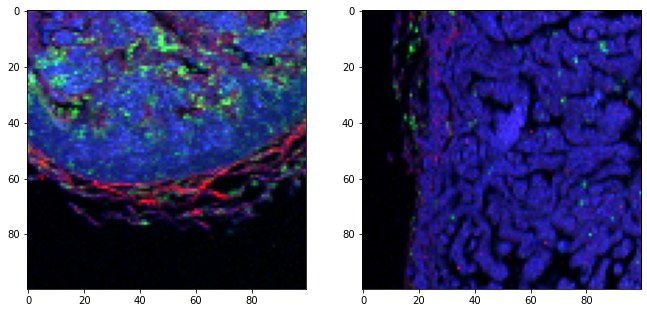

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images, filepaths will need altering to match users directory. 
img_A = mpimg.imread('C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Inj\\inj_1_3.png')  
img_B = mpimg.imread('C:/Users/cr1349/OneDrive - University of Bristol/Documents/Col_sub_images/Val_data\\Val_Sham\\shm_1_2.png') 

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

### Since the files in this dataset weren't shuffled we know that 1-3 are injured and 4-6 are uninjured hearts. In most instances the model accurately identifies each image as belonging to the correct category. The above images can be used to eyeball image number 3 and 5, which were injured and uninjered respectively. In some instances of the model there is less confidence in identifying uninjured heart images, which could be due to the individual images that are randomly assigned to the training dataset, or to the limited dataset size. In addition the parameters of the model could further be refined to increase the consistency and accuracy of the model. 

In [28]:
from platform import python_version
print(python_version())

3.8.5
